C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\4055150391.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


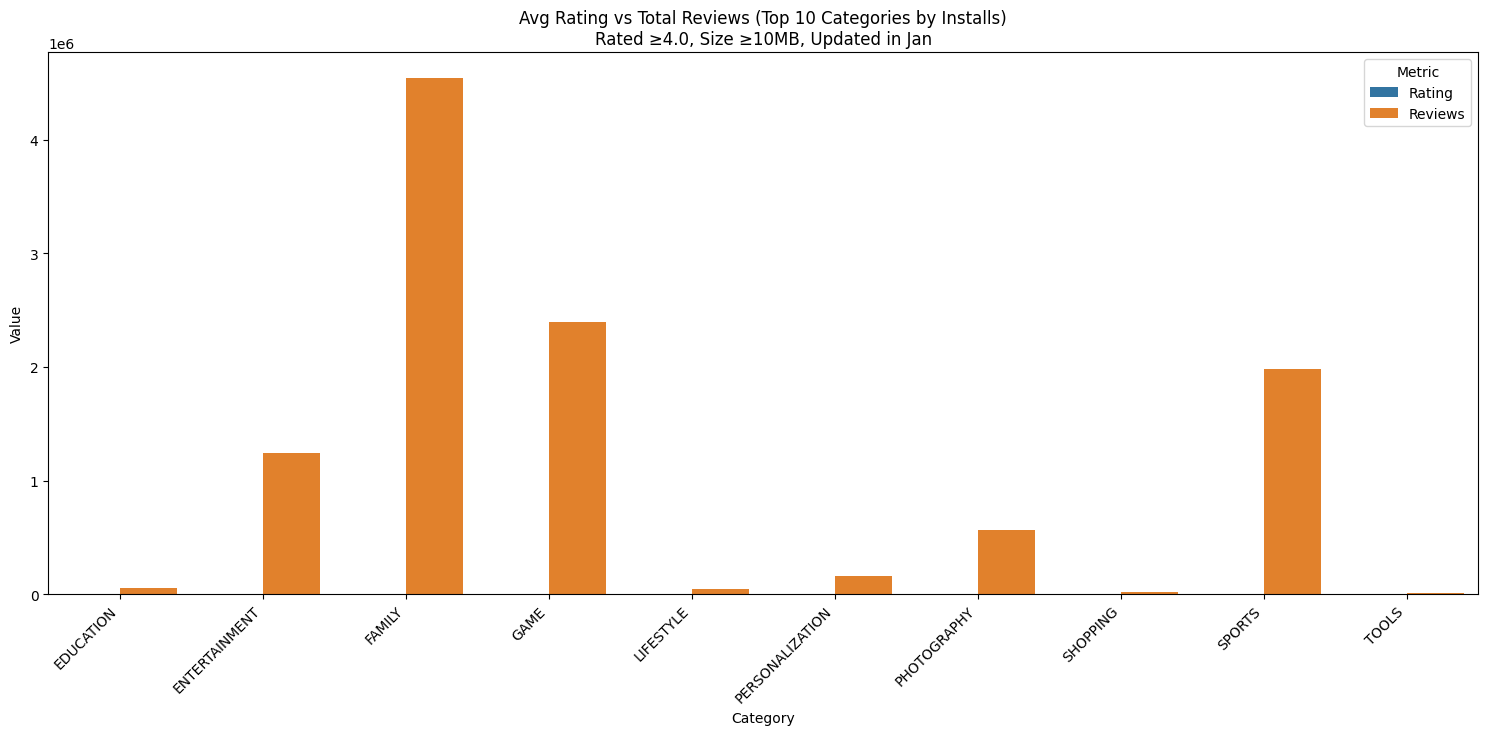

In [ ]:
#task 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from datetime import datetime
import pytz

def draw_grouped_bar_dashboard(apps_df, parent_frame):
    
    tz = pytz.timezone('Asia/Kolkata')
    now = datetime.now(tz)
    start_hour = 15  # 3 PM
    end_hour = 17   # 5 PM

    # Remove any prior widgets in frame
    for widget in parent_frame.winfo_children():
        widget.destroy()

    if not (start_hour <= now.hour < end_hour):
        label = tk.Label(parent_frame, text="This chart is only available between 3PM and 5PM IST.",
                         font=("Arial", 13), fg="red")
        label.pack(expand=True)
        return

    def parse_size(size):
        if isinstance(size, str):
            if 'M' in size:
                return float(size.replace('M', ''))
            elif 'k' in size:
                return float(size.replace('k', '')) / 1024
        return np.nan

    apps_df = apps_df.copy()
    apps_df['Size_M'] = apps_df['Size'].apply(parse_size)
    # Clean Installs column and convert to integer, coerce errors to NaN
    apps_df['InstallsInt'] = (
        apps_df['Installs'].astype(str)
        .str.replace('+', '', regex=False)
        .str.replace(',', '', regex=False)
    )
    apps_df['InstallsInt'] = pd.to_numeric(apps_df['InstallsInt'], errors='coerce').astype('Int64')
    apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')
    apps_df['Update_Month'] = apps_df['Last Updated'].dt.month

    filtered = apps_df[
        (apps_df['Rating'] >= 4.0) &
        (apps_df['Size_M'] >= 10) &
        (apps_df['Update_Month'] == 1)
    ]

    top_cats = (
        filtered.groupby('Category')['InstallsInt']
        .sum()
        .sort_values(ascending=False)
        .head(10)
        .index
    )
    filtered = filtered[filtered['Category'].isin(top_cats)]

    # Ensure Reviews column is numeric, coerce errors to NaN, then fill NaN with 0
    filtered['Reviews'] = pd.to_numeric(filtered['Reviews'], errors='coerce').fillna(0)

    plot_df = filtered.groupby('Category').agg({
        'Rating': 'mean',
        'Reviews': 'sum'
    }).reset_index()
    plot_df['Reviews'] = plot_df['Reviews'].astype(float)
    plot_df = plot_df.melt(id_vars='Category', value_vars=['Rating', 'Reviews'],
                           var_name='Metric', value_name='Value')

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Category', y='Value', hue='Metric', ax=ax)
    ax.set_title('Avg Rating vs Total Reviews (Top 10 Categories by Installs)\nRated ≥4.0, Size ≥10MB, Updated in Jan')
    ax.set_xlabel('Category')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()
    canvas = FigureCanvasTkAgg(fig, master=parent_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(expand=True, fill="both")


class AppDashboard(tk.Tk):
    def __init__(self, apps_df):
        super().__init__()
        self.title("Google Play Store Grouped Bar Chart Dashboard")
        self.geometry("1200x700")
        self.configure(bg='white')

        main_frame = ttk.Frame(self, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)

        chart_frame = ttk.Frame(main_frame)
        chart_frame.pack(fill=tk.BOTH, expand=True)

        draw_grouped_bar_dashboard(apps_df, chart_frame)

if __name__ == "__main__":
    apps_df = pd.read_csv('Play-Store-Data.csv')
    app = AppDashboard(apps_df)
    app.mainloop()


In [2]:
pip install --upgrade kaleido

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#task 2
import pandas as pd
import numpy as np
import pytz
from datetime import datetime
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import plotly.express as px
from PIL import Image, ImageTk
import matplotlib.pyplot as plt


apps_df = pd.read_csv('Play-Store-Data.csv')
apps_df = apps_df.dropna(subset=['Rating', 'Installs', 'Category'])
apps_df['Installs'] = apps_df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
apps_df = apps_df[apps_df['Installs'].str.isdigit()]
apps_df['Installs'] = apps_df['Installs'].astype(float)

# Time Window Function (6PM–8PM IST)
def is_in_time_window():
    IST = pytz.timezone('Asia/Kolkata')
    now_ist = datetime.now(IST)
    return 18 <= now_ist.hour < 20


mask = ~apps_df['Category'].str.startswith(('A', 'C', 'G', 'S'))
filtered_df = apps_df[mask]
top_categories = filtered_df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(5)
filtered_df = filtered_df[filtered_df['Category'].isin(top_categories.index)]

#
if 'Country' not in filtered_df.columns:
    countries = ['USA', 'India', 'Brazil', 'UK', 'Germany', 'Russia', 'France', 'Japan', 'South Korea', 'Australia']
    filtered_df['Country'] = np.random.choice(countries, size=len(filtered_df))

installs_by_country_category = filtered_df.groupby(['Country', 'Category'])['Installs'].sum().reset_index()
installs_by_country_category['Highlight'] = installs_by_country_category['Installs'] > 1_000_000


class PlayStoreDashboard(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Global Installs by Category (Top 5, Time-Constrained)")
        self.geometry('1920x1080')
        self.configure(bg='lightgray')

        # Dropdown for Categories
        self.category_var = tk.StringVar()
        self.category_dropdown = ttk.Combobox(self, textvariable=self.category_var, state="readonly")
        self.category_dropdown['values'] = list(top_categories.index)
        self.category_dropdown.current(0)
        self.category_dropdown.bind('<<ComboboxSelected>>', self.update_plot)
        self.category_dropdown.pack(pady=10)

        # Warning Label
        self.warning_label = tk.Label(self, text="", fg="red", bg='lightgray', font=("Arial", 12))
        self.warning_label.pack()

        # Plot Frame
        self.plot_frame = tk.Frame(self, bg='lightgray')
        self.plot_frame.pack(fill="both", expand=True)

        self.update_plot()

    def update_plot(self, event=None):
        # Clear previous plot
        for widget in self.plot_frame.winfo_children():
            widget.destroy()

        if not is_in_time_window():
            self.warning_label.config(text="This map is only available 6-8PM IST.")
            return

        self.warning_label.config(text="")
        selected_category = self.category_var.get() if self.category_var.get() else list(top_categories.index)[0]
        df = installs_by_country_category[installs_by_country_category['Category'] == selected_category]

      
        fig = px.choropleth(
            df,
            locations='Country',
            locationmode='country names',
            color='Installs',
            hover_name='Country',
            title=f'{selected_category}: Global Installs',
            color_continuous_scale='YlGnBu'
        )
        
        highlighted = df[df['Highlight']]
        for country in highlighted['Country']:
            fig.add_scattergeo(
                locations=[country],
                locationmode='country names',
                marker=dict(size=14, color='red', symbol='star'),
                name=f"High Installs ({country})"
            )

        
        fig.write_image("choropleth.png")
        choropleth_img = Image.open("choropleth.png")
        # Use Image.Resampling.LANCZOS for newer Pillow versions
        img_resized = choropleth_img.resize((1000, 1000), Image.Resampling.LANCZOS)
        img_tk = ImageTk.PhotoImage(img_resized)
        label = tk.Label(self.plot_frame, image=img_tk)
        label.image = img_tk
        label.pack(padx=10, pady=10)

if __name__ == '__main__':
    PlayStoreDashboard().mainloop()


C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\3320244793.py:80: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\3320244793.py:80: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\3320244793.py:80: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.

C:\Users\rattu\A

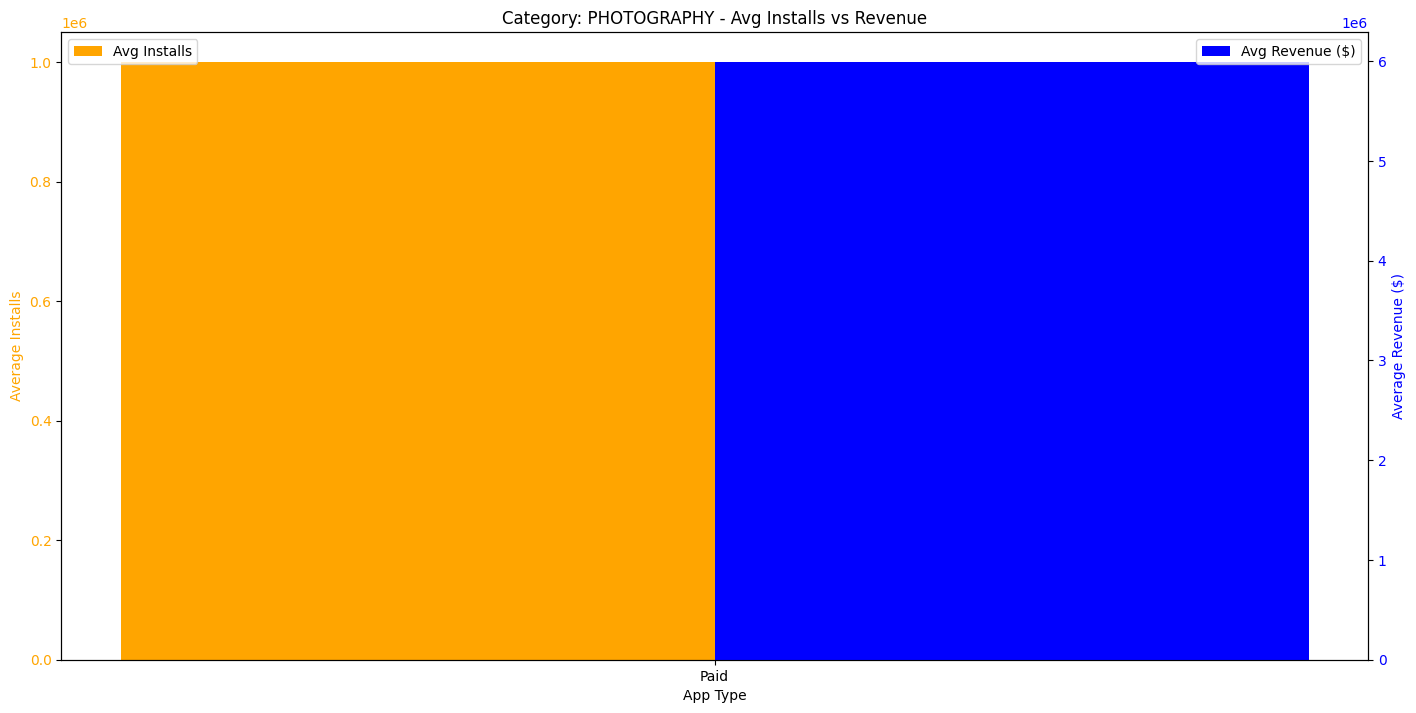

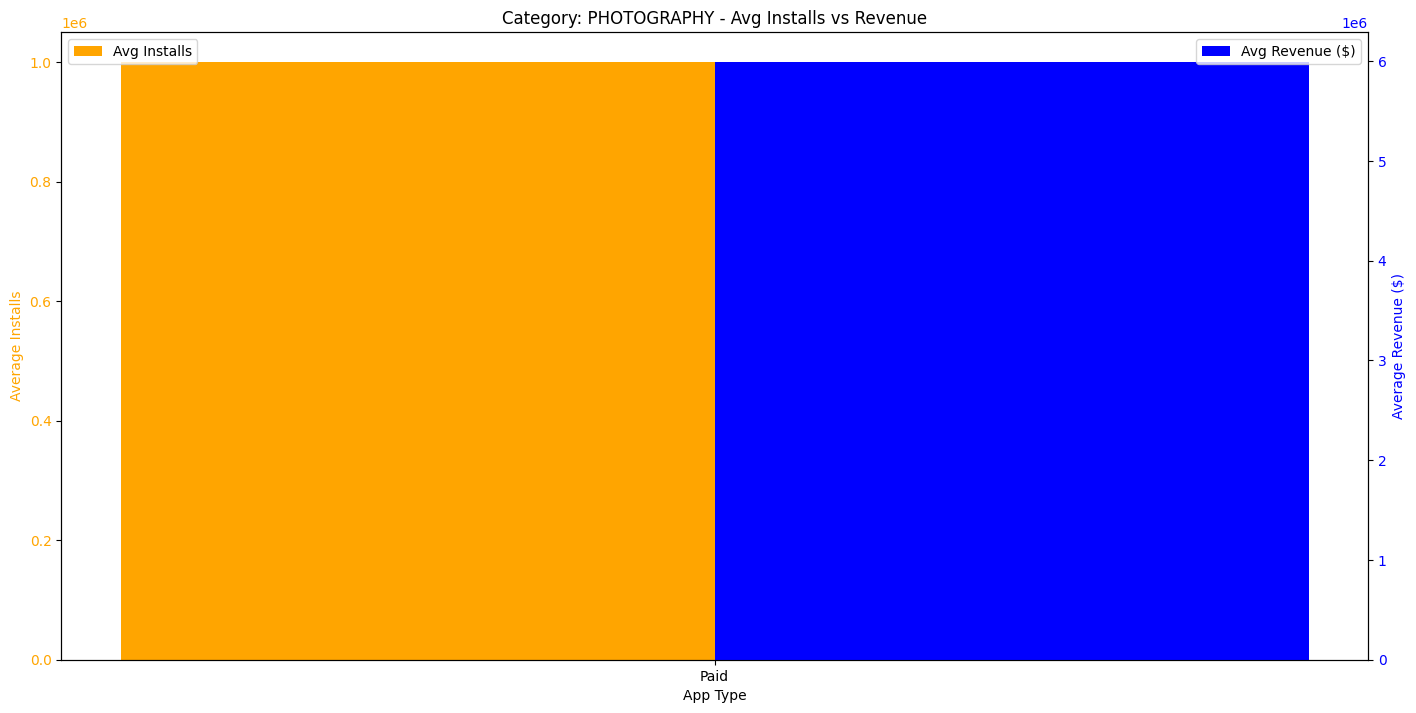

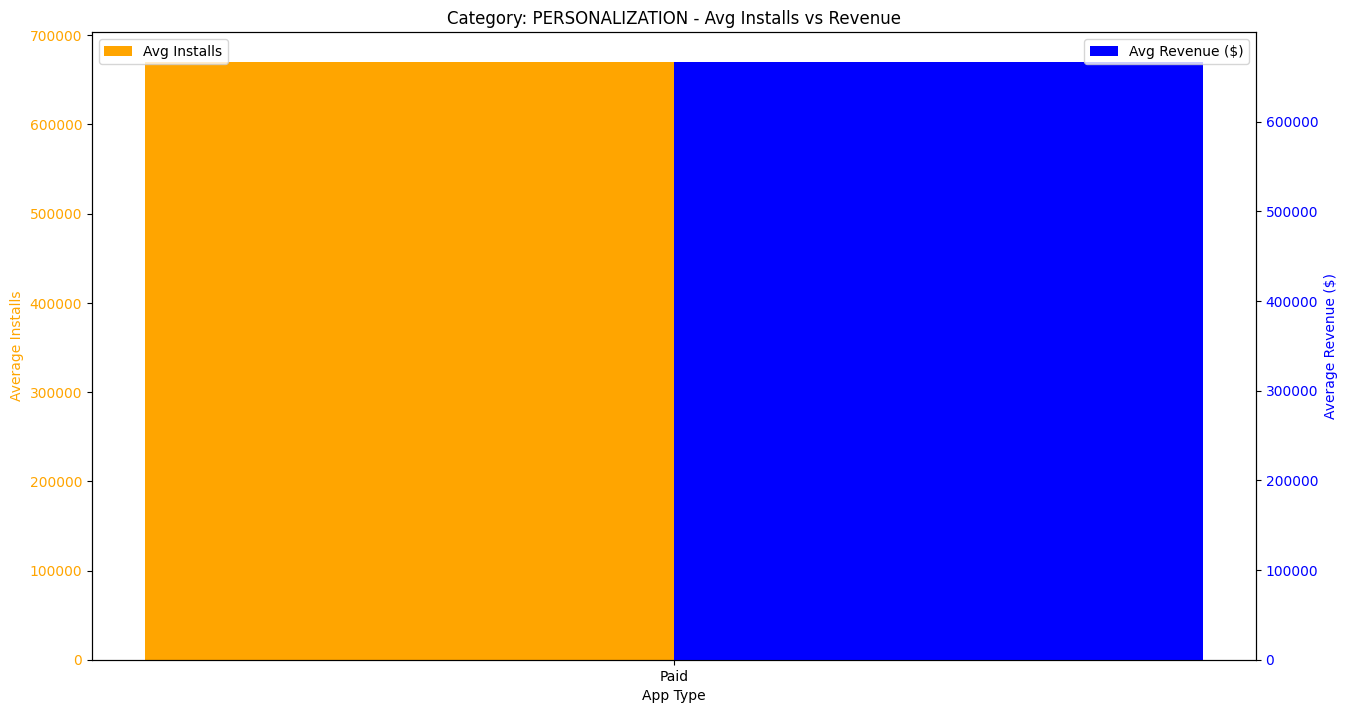

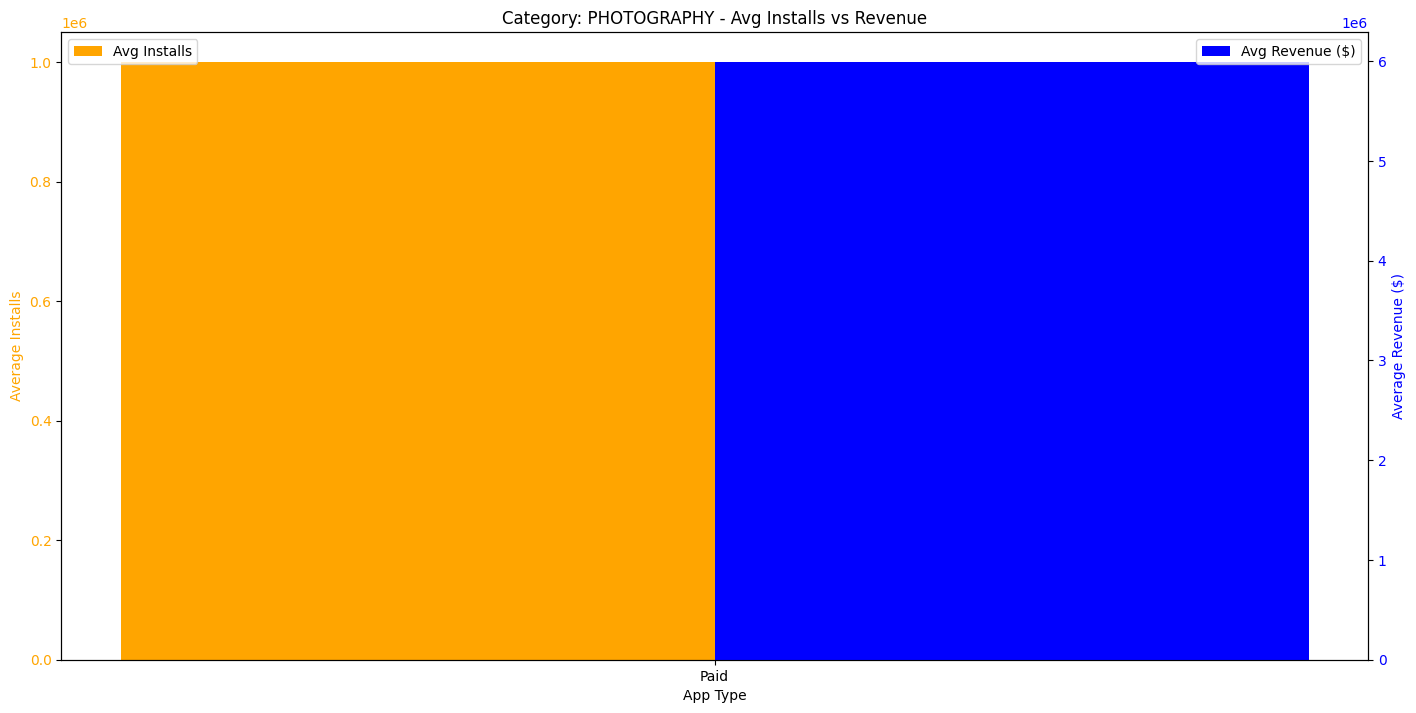

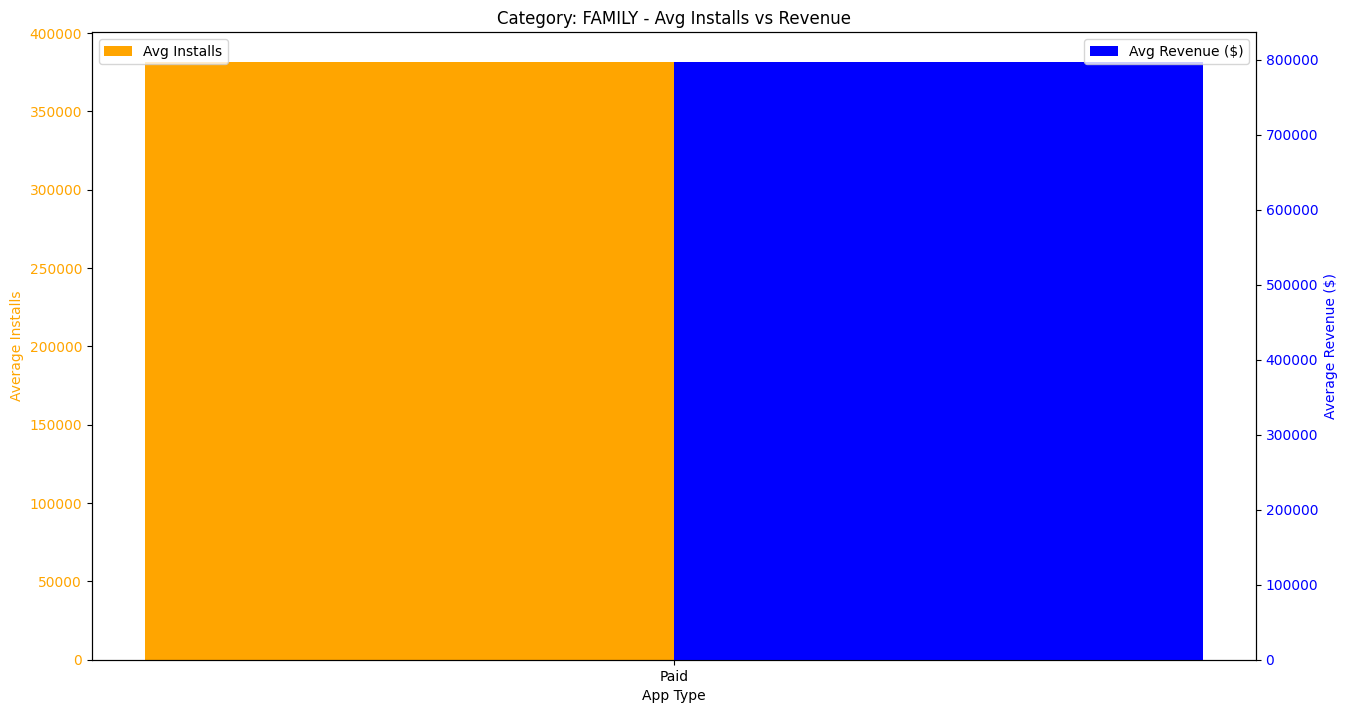

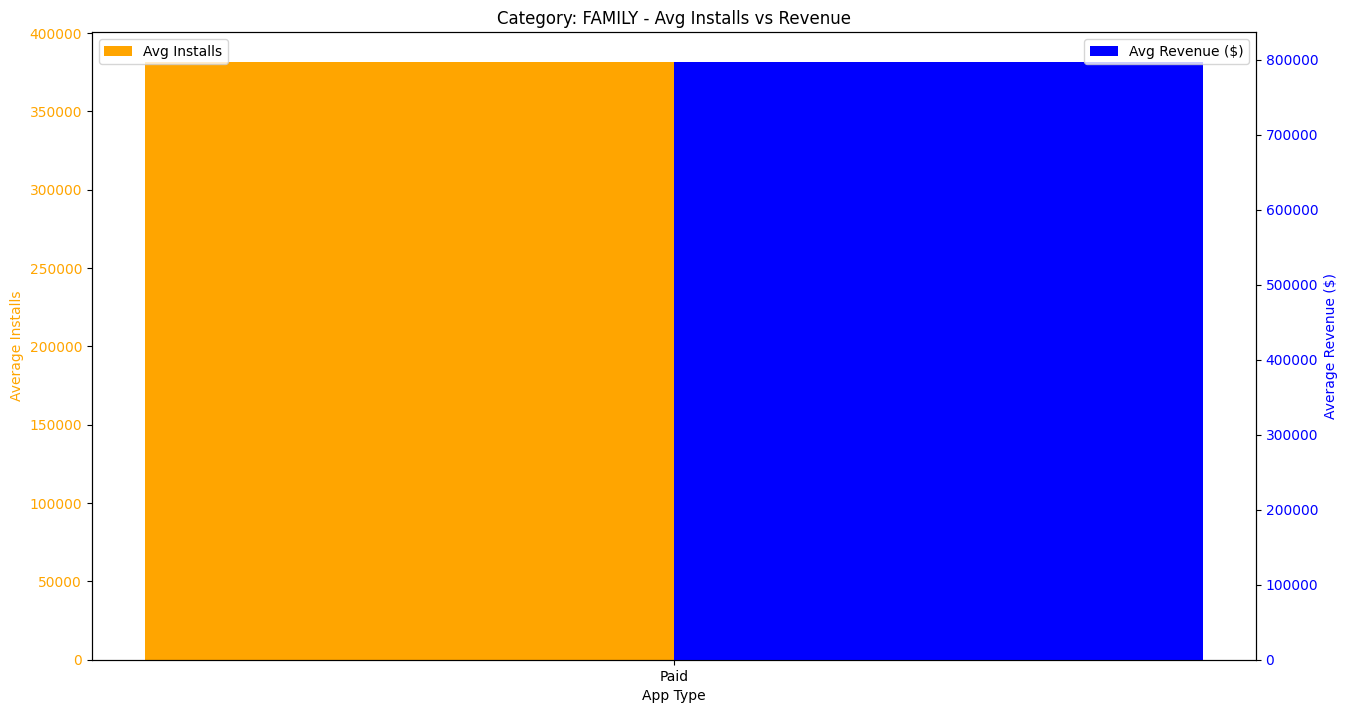

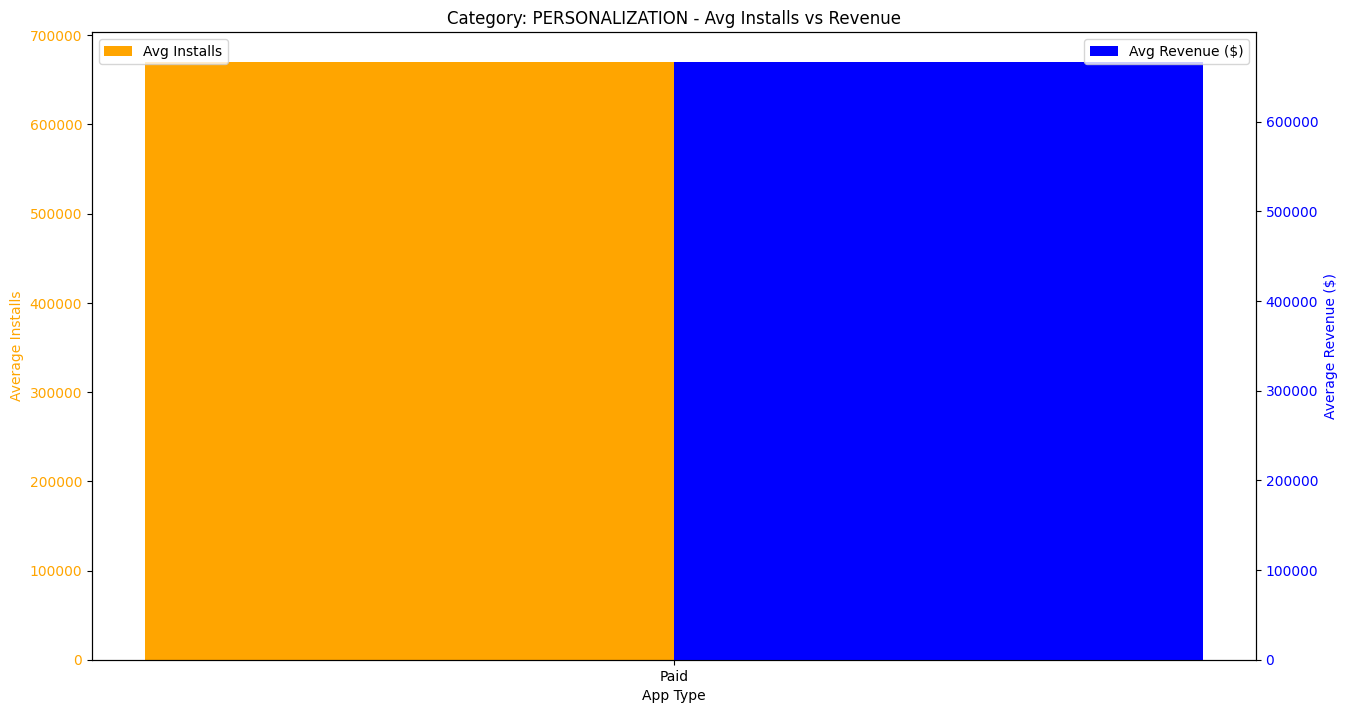

In [ ]:
#task 3
import pandas as pd
import numpy as np
import pytz
from datetime import datetime
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import re


apps_df = pd.read_csv('Play-Store-Data.csv')


apps_df = apps_df.dropna(subset=['Installs', 'Android Ver', 'Size', 'Content Rating', 'App', 'Category', 'Type'])

apps_df['Installs'] = apps_df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
apps_df = apps_df[apps_df['Installs'].str.isdigit()]
apps_df['Installs'] = apps_df['Installs'].astype(int)

# Calculate Revenue = Price * Installs
apps_df['Price'] = apps_df['Price'].astype(str).str.replace('$', '').astype(float)
apps_df['Revenue'] = apps_df['Price'] * apps_df['Installs']

# Convert Size to MB
def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
    return np.nan
apps_df['Size_MB'] = apps_df['Size'].apply(convert_size)

#
def extract_android_ver(ver):
    if isinstance(ver, str):
        m = re.search(r'\d+\.\d+', ver)
        if m:
            return float(m.group())
        m2 = re.search(r'\d+', ver)
        if m2:
            return float(m2.group())
    return np.nan
apps_df['Android_Ver_Num'] = apps_df['Android Ver'].apply(extract_android_ver)

# Apply filters
filtered = apps_df[
    (apps_df['Installs'] >= 10000) &
    (apps_df['Revenue'] >= 10000) &
    (apps_df['Android_Ver_Num'] > 4.0) &
    (apps_df['Size_MB'] > 15) &
    (apps_df['Content Rating'] == 'Everyone') &
    (apps_df['App'].str.len() <= 30)
]

# Identify top 3 categories by installs
top3_cats = filtered.groupby('Category')['Installs'].sum().nlargest(3).index.tolist()
filtered_top3 = filtered[filtered['Category'].isin(top3_cats)]

# Aggregate average installs and revenue by Category and Type
agg_df = filtered_top3.groupby(['Category', 'Type']).agg({'Installs':'mean', 'Revenue':'mean'}).reset_index()

# Time check for IST 1 PM to 2 PM
def is_time_between_1_and_2pm():
    ist = pytz.timezone('Asia/Kolkata')
    now = datetime.now(ist)
    return 13 <= now.hour < 15

# Tkinter Dashboard class
class DualAxisDashboard(tk.Tk):
    def __init__(self, data):
        super().__init__()
        self.title("Avg Installs & Revenue by Free vs Paid Apps (Top 3 Categories)")
        self.geometry('900x600')

        self.data = data

        # Category drop-down for selection
        self.category_var = tk.StringVar()
        self.category_dropdown = ttk.Combobox(self, textvariable=self.category_var, values=top3_cats, state='readonly')
        self.category_dropdown.current(0)
        self.category_dropdown.pack(pady=10)
        self.category_dropdown.bind('<<ComboboxSelected>>', self.update_chart)

        # Warning label for time restriction
        self.warning_label = tk.Label(self, fg='red', font=('Arial', 12))
        self.warning_label.pack()

        # Chart area frame
        self.chart_frame = tk.Frame(self)
        self.chart_frame.pack(fill='both', expand=True)

        self.canvas = None
        self.update_chart()

    def update_chart(self, event=None):
        # Clear chart and messages
        for widget in self.chart_frame.winfo_children():
            widget.destroy()
        self.warning_label.config(text='')

        if not is_time_between_1_and_2pm():
            self.warning_label.config(text='This graph is only visible between 1 PM and 2 PM IST.')
            return

        category = self.category_var.get() or top3_cats[0]
        df = self.data[self.data['Category'] == category]

        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax2 = ax1.twinx()

        width = 0.3
        x = np.arange(len(df))

        ax1.bar(x - width/2, df['Installs'], width, label='Avg Installs', color='orange')
        ax2.bar(x + width/2, df['Revenue'], width, label='Avg Revenue ($)', color='blue')

        ax1.set_xticks(x)
        ax1.set_xticklabels(df['Type'])

        ax1.set_xlabel('App Type')
        ax1.set_ylabel('Average Installs', color='orange')
        ax2.set_ylabel('Average Revenue ($)', color='blue')

        ax1.tick_params(axis='y', labelcolor='orange')
        ax2.tick_params(axis='y', labelcolor='blue')

        ax1.set_title(f'Category: {category} - Avg Installs vs Revenue')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        fig.tight_layout()

        self.canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill='both', expand=True)

if __name__ == '__main__':
    app = DualAxisDashboard(agg_df)
    app.mainloop()


C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Matplotlib currently does not support Devanagari natively.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Glyph 2380 (\N{DEVANAGARI VOWEL SIGN AU}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWarning:

Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\226559094.py:126: UserWar

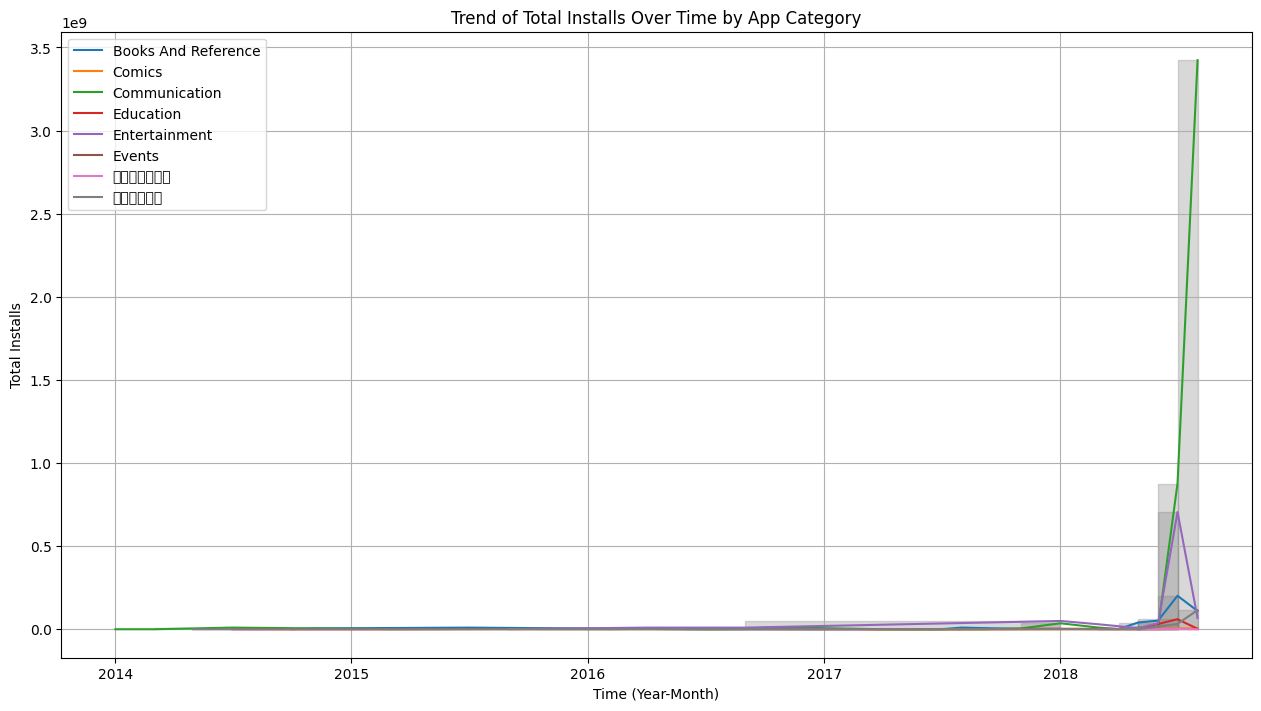

In [ ]:
import pandas as pd
import numpy as np
import pytz
from datetime import datetime
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import seaborn as sns

apps_df = pd.read_csv('Play-Store-Data.csv')

apps_df.dropna(subset=['Installs', 'Category', 'App', 'Last Updated', 'Reviews'], inplace=True)

# Clean Installs column
def clean_installs(x):
    try:
        val = str(x).replace(',', '').replace('+', '').strip()
        return int(val) if val.isdigit() else np.nan
    except:
        return np.nan

apps_df['Installs'] = apps_df['Installs'].apply(clean_installs)
apps_df.dropna(subset=['Installs'], inplace=True)
apps_df['Installs'] = apps_df['Installs'].astype(int)

# Ensure Reviews is numeric and filter
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'], errors='coerce')
apps_df.dropna(subset=['Reviews'], inplace=True)
apps_df['Reviews'] = apps_df['Reviews'].astype(int)

# Convert Last Updated to datetime
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')
apps_df.dropna(subset=['Last Updated'], inplace=True)

# Filter on category and app name conditions
apps_df = apps_df[
    apps_df['Category'].str.startswith(('E','C','B')) &
    ~apps_df['App'].str.startswith(('x','y','z')) &
    ~apps_df['App'].str.contains('S', case=False) &
    (apps_df['Reviews'] > 500)
]


translation_map = {
    'Beauty': 'सौंदर्य',
    'Business': 'வணிகம்',
    'Dating': 'Dating in German'  
}

def translate_category(cat):
    cat_clean = cat.replace('_', ' ').title()
    return translation_map.get(cat_clean, cat_clean)

apps_df['Category_Translated'] = apps_df['Category'].apply(translate_category)

# Create YearMonth column for aggregation
apps_df['YearMonth'] = apps_df['Last Updated'].dt.to_period('M')

# Aggregate installs by YearMonth and Category_Translated
monthly_installs = apps_df.groupby(['YearMonth', 'Category_Translated'])['Installs'].sum().reset_index()

# Calculate MoM percentage change to find significant growth
monthly_installs['Installs_pct_change'] = monthly_installs.groupby('Category_Translated')['Installs'].pct_change()
monthly_installs['Significant_Growth'] = monthly_installs['Installs_pct_change'] > 0.20

# Time gate for 6 PM to 9 PM IST
def is_in_time_window():
    IST = pytz.timezone('Asia/Kolkata')
    now_ist = datetime.now(IST)
    return 18 <= now_ist.hour < 21

# Plot function with shading for significant growth
def plot_time_series_with_growth(ax):
    for cat, group in monthly_installs.groupby('Category_Translated'):
        group_sorted = group.sort_values('YearMonth')
        ax.plot(group_sorted['YearMonth'].dt.to_timestamp(), group_sorted['Installs'], label=cat)
        # Shade growth periods
        for i in range(1, len(group_sorted)):
            if group_sorted.iloc[i]['Significant_Growth']:
                start = group_sorted.iloc[i-1]['YearMonth'].to_timestamp()
                end = group_sorted.iloc[i]['YearMonth'].to_timestamp()
                y_bottom = 0
                y_top = group_sorted.iloc[i]['Installs']
                ax.fill_between([start, end], y_bottom, y_top, color='gray', alpha=0.3)

    ax.set_title('Trend of Total Installs Over Time by App Category')
    ax.set_xlabel('Time (Year-Month)')
    ax.set_ylabel('Total Installs')
    ax.legend()
    ax.grid(True)

# Tkinter dashboard class
class InstallsDashboard(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("App Installs Trend Dashboard")
        self.geometry('1000x600')
        self.configure(bg='white')

        self.plot_frame = tk.Frame(self, bg='white')
        self.plot_frame.pack(fill='both', expand=True)

        self.warning_label = tk.Label(self, text='', fg='red', bg='white', font=('Arial', 14))
        self.warning_label.pack()

        self.draw_or_hide_chart()

        # Update every minute to check time window
        self.after(60000, self.check_time_and_update)

    def draw_or_hide_chart(self):
        # Clear previous widgets
        for widget in self.plot_frame.winfo_children():
            widget.destroy()

        if not is_in_time_window():
            self.warning_label.config(text="This chart is only available between 6 PM to 9 PM IST.")
            return
        else:
            self.warning_label.config(text='')

        fig, ax = plt.subplots(figsize=(12, 6))
        plot_time_series_with_growth(ax)

        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True)

    def check_time_and_update(self):
        self.draw_or_hide_chart()
        self.after(60000, self.check_time_and_update)


if __name__ == '__main__':
    app = InstallsDashboard()
    app.mainloop()


C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\2109847401.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\2109847401.py:134: UserWarning:

Glyph 2997 (\N{TAMIL LETTER VA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\2109847401.py:134: UserWarning:

Matplotlib currently does not support Tamil natively.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\2109847401.py:134: UserWarning:

Glyph 2979 (\N{TAMIL LETTER NNA}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21080\2109847401.py:134: UserWarning:

Glyph 3007 (\N{TAMIL VOWEL SIGN I}) missing from font(s) DejaVu Sans.

C:\Users\rattu\AppData\Local\Temp\ipykernel_21

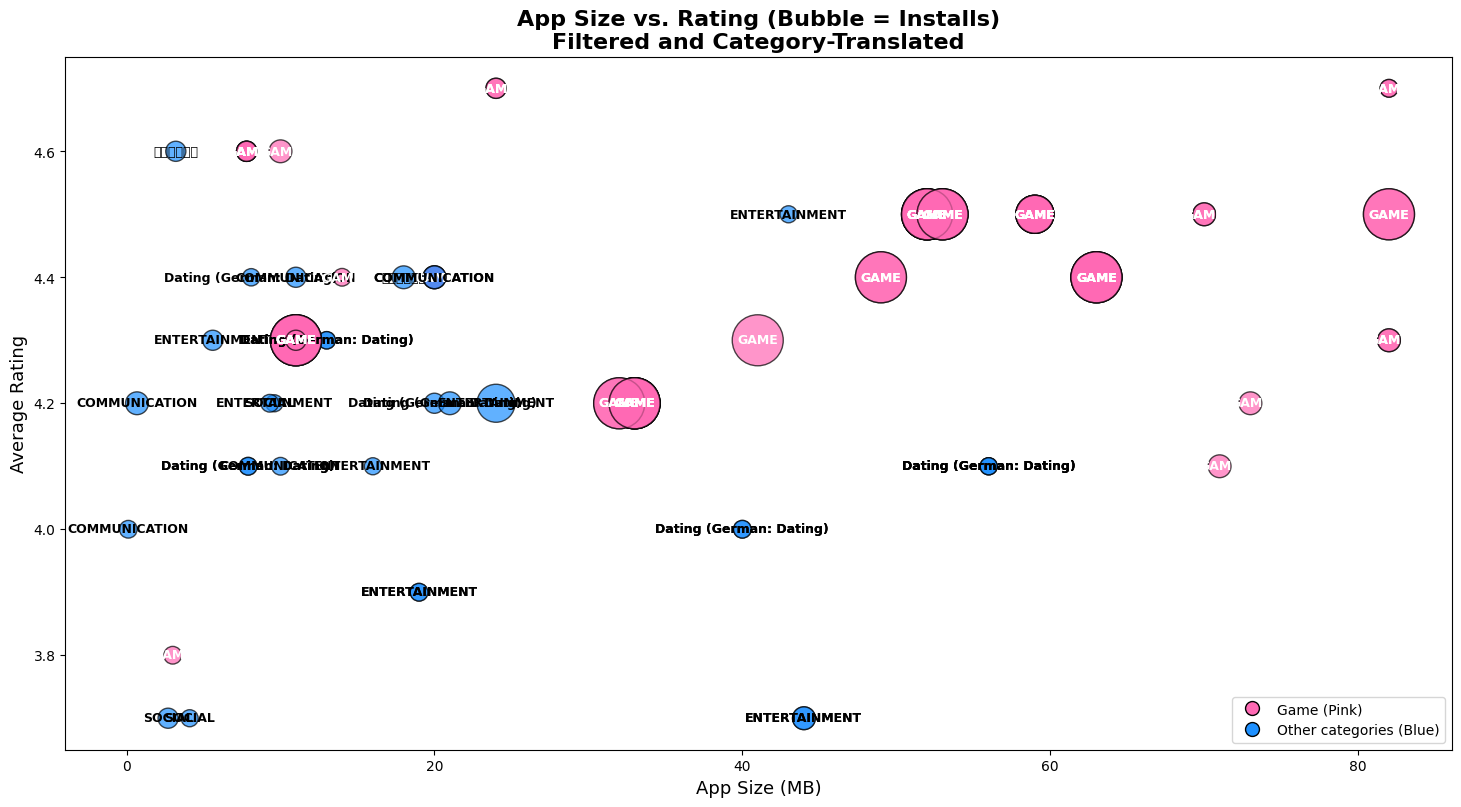

In [ ]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import datetime
import pytz

#
apps = pd.read_csv('Play-Store-Data.csv')
reviews = pd.read_csv('User Reviews.csv')


categories_to_keep = [
    'GAME', 'BEAUTY', 'BUSINESS', 'COMICS', 'COMMUNICATION', 
    'DATING', 'ENTERTAINMENT', 'SOCIAL', 'EVENT'
]
apps = apps[apps['Category'].str.upper().isin(categories_to_keep)]

# Remove apps whose names contain the letter "S" or "s"
apps = apps[apps['App'].str.lower().str.contains('s') == False]

# Remove apps with reviews <= 500
apps = apps[apps['Reviews'].astype(float) > 500]

# Only keep apps with rating > 3.5 and installs > 50,000
apps = apps[apps['Rating'].astype(float) > 3.5]
def parse_installs(val):
    if isinstance(val, str):
        return int(val.replace('+','').replace(',',''))
    return np.nan
apps['InstallsInt'] = apps['Installs'].apply(parse_installs)
apps = apps[apps['InstallsInt'] > 50000]

# Convert Size column to MB (float)
def parse_size(x):
    if isinstance(x, str):
        if 'M' in x:
            return float(x.replace('M',''))
        elif 'k' in x:
            return float(x.replace('k',''))/1024
    return np.nan
apps['SizeMB'] = apps['Size'].apply(parse_size)

# 
reviews = reviews.dropna(subset=['Sentiment_Subjectivity'])
reviews['Sentiment_Subjectivity'] = reviews['Sentiment_Subjectivity'].astype(float)
reviews_high = reviews[reviews['Sentiment_Subjectivity'] > 0.5]

# 
app_list_subj = set(reviews_high['App'])
apps = apps[apps['App'].isin(app_list_subj)]

# 
category_map = {
    "BEAUTY": "सौंदर्य", # Hindi
    "BUSINESS": "வணிகம்", # Tamil
    "DATING": "Dating (German: Dating)" # We'll use "Dating" since no translation provided
}
def translate(cat):
    if cat.upper() in category_map:
        return category_map[cat.upper()]
    return cat
apps['Category_Display'] = apps['Category'].apply(translate)

# --- IST Time Restriction Function ---
def is_time_in_IST_window():
    tz = pytz.timezone('Asia/Kolkata')
    now = datetime.datetime.now(tz)
    return now.hour >= 17 and now.hour < 21

# --- Tkinter Dashboard ----
class DashboardApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("App Size vs Rating Bubble Chart")
        self.geometry("1000x700")
        self.configure(bg='white')
        # Main frame
        self.main_frame = ttk.Frame(self, padding="10")
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        if is_time_in_IST_window():
            self.draw_bubble_chart()
        else:
            self.show_time_warning()

    def draw_bubble_chart(self):
        # Choose filtered data (avoid apps with NaNs in Size or Rating)
        df = apps.dropna(subset=['SizeMB', 'Rating', 'InstallsInt'])
        if df.empty:
            label = tk.Label(self.main_frame, text="No data matches the filter criteria.", fg="red", font=("Arial", 18))
            label.pack(expand=True)
            return

       
        def pick_color(cat):
            return 'hotpink' if cat.upper() == 'GAME' else 'dodgerblue'

        df['Color'] = df['Category'].apply(pick_color)
        fig, ax = plt.subplots(figsize=(10,8))

        sizes = df['InstallsInt']/df['InstallsInt'].max() * 1200 + 150

        scatter = ax.scatter(
            df['SizeMB'], df['Rating'],
            s=sizes,
            c=df['Color'],
            alpha=0.7,
            edgecolor='black'
        )

        # Add category labels at bubble centers
        for _, row in df.iterrows():
            ax.text(
                row['SizeMB'], row['Rating'],
                row['Category_Display'], fontsize=9,
                ha='center', va='center',
                color='white' if row['Color'] == 'hotpink' else 'black',
                weight='bold'
            )
        ax.set_xlabel('App Size (MB)', fontsize=13)
        ax.set_ylabel('Average Rating', fontsize=13)
        ax.set_title('App Size vs. Rating (Bubble = Installs)\nFiltered and Category-Translated', fontsize=16, fontweight='bold')

        # Legend
        from matplotlib.lines import Line2D
        custom_legend = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='hotpink', markeredgecolor='black', markersize=10, label='Game (Pink)'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', markeredgecolor='black', markersize=10, label='Other categories (Blue)')
        ]
        ax.legend(handles=custom_legend, loc='lower right', frameon=True)

        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=self.main_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def show_time_warning(self):
        label = tk.Label(self.main_frame,
            text="Bubble chart is only available between 5 PM and 7 PM IST.",
            font=("Arial", 17,"bold"), fg="red"
        )
        label.pack(expand=True, anchor='center')

if __name__ == '__main__':
    app = DashboardApp()
    app.mainloop()


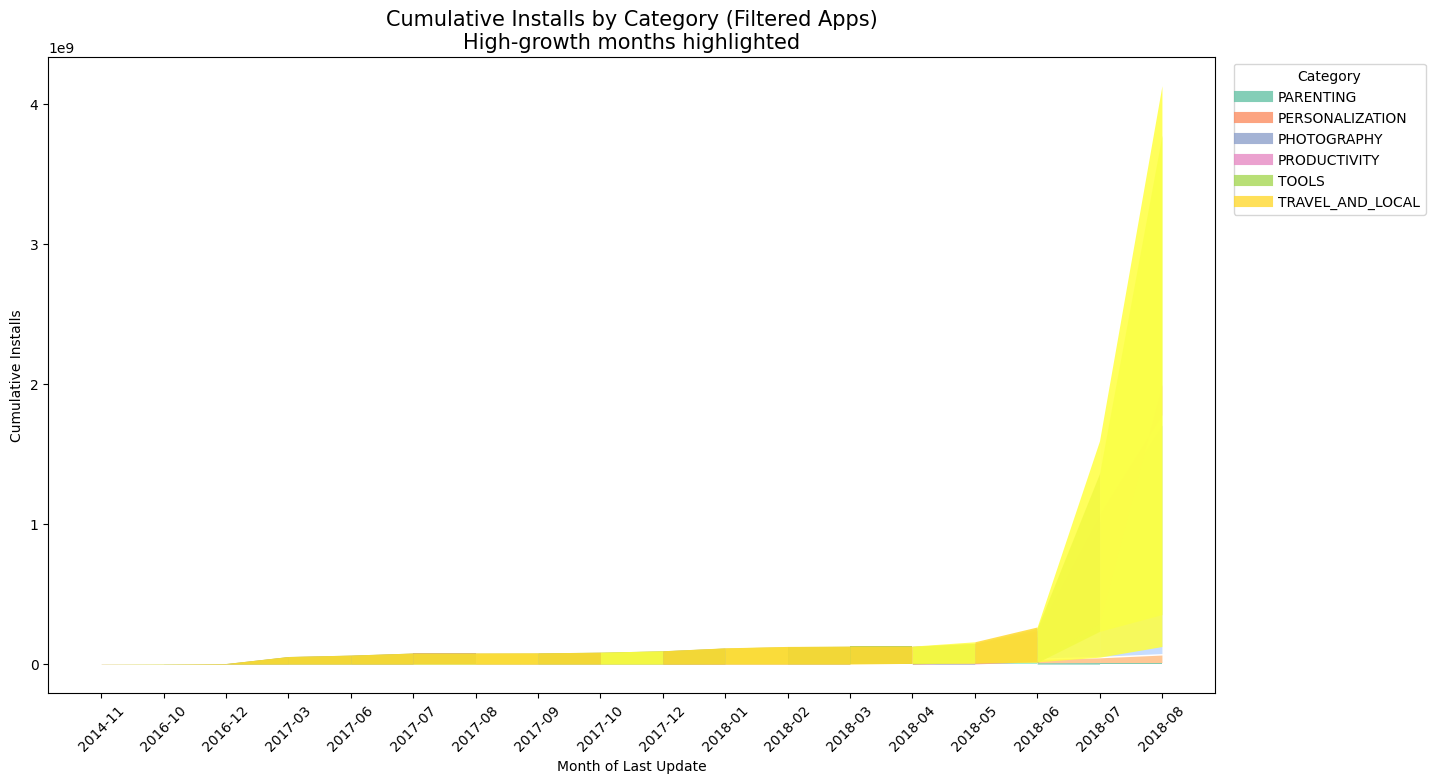

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import re
from datetime import datetime
import pytz

def stacked_area_chart_dashboard(apps_df, parent_frame):
    # --- Time gating logic (IST aware) ---
    tz = pytz.timezone('Asia/Kolkata')
    now = datetime.now(tz)
    if not (16 <= now.hour < 21):
        for widget in parent_frame.winfo_children():
            widget.destroy()
        label = tk.Label(
            parent_frame,
            text="This chart is only available between 4 PM and 6 PM IST.",
            font=("Arial", 13), fg="red"
        )
        label.pack(expand=True)
        return

    # --- Filters ---
    # Size: convert to MB float where possible
    def parse_size(size_str):
        if isinstance(size_str, str):
            if 'M' in size_str:
                try:
                    return float(size_str.replace('M',''))
                except Exception:
                    return np.nan
            elif 'k' in size_str:
                try:
                    return float(size_str.replace('k',''))/1024
                except Exception:
                    return np.nan
        return np.nan

    df = apps_df.copy()
    df['Size_MB'] = df['Size'].apply(parse_size)
    # Filter: rating >= 4.2
    df = df[(df['Rating'] >= 4.2)]
    # App name: no numbers
    df = df[~df['App'].str.contains(r'[0-9]', na=False)]
    # Category: starts with T or P
    df = df[df['Category'].str.startswith(('T','P'), na=False)]
    # Reviews > 1000
    df = df[pd.to_numeric(df['Reviews'], errors='coerce') > 1000]
    # Size 20–80MB
    df = df[(df['Size_MB'] >= 20) & (df['Size_MB'] <= 80)]
    # Installs: clean to int
    df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
    df = df[df['Installs'].str.isdigit()]
    df['Installs'] = df['Installs'].astype(int)
    # Last Updated date
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df = df.dropna(subset=['Last Updated'])
    # Group by category and month
    df['YYYYMM'] = df['Last Updated'].dt.to_period('M')
    grouped = df.groupby(['YYYYMM','Category'])['Installs'].sum().unstack(fill_value=0)
    # Sort columns alphabetically for consistent color mapping
    grouped = grouped.sort_index(axis=1)
    # Calculate cumulative installs by category over time
    cum_installs = grouped.cumsum()

    # --- Translate legend labels
    legend_mapping = {
        "Travel & Local": "Voyages et localités",  # French
        "Productivity": "Productividad",           # Spanish
        "Photography": "写真"                      # Japanese (shashin)
    }
    display_names = [
        legend_mapping.get(cat, cat) for cat in cum_installs.columns
    ]
    # --- Month-over-month growth detection
    pct_change = cum_installs.diff().div(cum_installs.shift(1)).fillna(0)
    highlight_months = (pct_change > 0.25)  # DataFrame: True where >25% MoM growth per cat

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12,7))
    colors = sns.color_palette("Set2", n_colors=cum_installs.shape[1])
    # Draw area stacks one by one for highlight logic
    prev = np.zeros_like(cum_installs.iloc[:,0])
    handles = []
    for i, col in enumerate(cum_installs.columns):
        base = prev
        vals = cum_installs[col].values
        # Highlight logic: increase color intensity for months where >25% MoM growth
        this_color = list(colors[i])
        # We will use fill_between to draw segmentwise with color intensity
        for j in range(len(cum_installs)):
            if highlight_months.iloc[j, i]:
                highlight_c = tuple(min(1.0, c*1.35) for c in this_color)
            else:
                highlight_c = tuple(this_color)
            ax.fill_between(
                cum_installs.index.astype(str)[j:j+2] if j+1<len(cum_installs) else cum_installs.index.astype(str)[j:j+1],
                base[j:j+2] if j+1<len(cum_installs) else base[j:j+1],
                vals[j:j+2] if j+1<len(cum_installs) else vals[j:j+1],
                color=highlight_c,
                alpha=0.85,
                linewidth=0
            )
        prev = prev + vals

    # Legend
    for i, cat in enumerate(cum_installs.columns):
        handles.append(
            plt.Line2D([0], [0], color=colors[i], lw=8, label=display_names[i], alpha=0.8)
        )
    ax.legend(handles=handles, title='Category', bbox_to_anchor=(1.01, 1), loc='upper left')

    ax.set_title("Cumulative Installs by Category (Filtered Apps)\nHigh-growth months highlighted", fontsize=15)
    ax.set_xlabel("Month of Last Update")
    ax.set_ylabel("Cumulative Installs")
    ax.set_xticks(np.arange(len(cum_installs.index)))
    ax.set_xticklabels([str(period) for period in cum_installs.index], rotation=45)
    fig.tight_layout()

    for widget in parent_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=parent_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(expand=True, fill="both")

# --- Main Tkinter dashboard template
class AppDashboard(tk.Tk):
    def __init__(self, apps_df):
        super().__init__()
        self.title("Stacked Area Chart: Cumulative Installs Over Time by Category")
        self.geometry("1280x720")
        self.configure(bg="white")

        main_frame = ttk.Frame(self, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)

        chart_frame = ttk.Frame(main_frame)
        chart_frame.pack(fill=tk.BOTH, expand=True)

        # Draw the chart (with time gating logic inside)
        stacked_area_chart_dashboard(apps_df, chart_frame)

if __name__ == "__main__":
    df = pd.read_csv('Play-Store-Data.csv')
    app = AppDashboard(df)
    app.mainloop()
